In [ ]:
import xgboost
from sklearn.model_selection import KFold, cross_validate,cross_val_predict, StratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.utils import compute_class_weight
from sklearn.preprocessing import normalize
from sklearn import svm
import matplotlib.pyplot as plt
from vis_utils import plot_confusion_matrix
from constants import LABEL_MAP, CLASSES_NAMES, TAG_KEYWORDS
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam

LOADING DATA
======

Loading the data from the sections.csv into a pandas dataframe, saved by executing the firebase_data_export notebook (not available in the public repository).

All the instances (with their features) are stored din data as a numpy array.

The labels of the instances are stored in labels as a numpy array as well.

In [2]:
section_data = pd.read_csv('sections.csv')
features = list(section_data.columns.values)
# removing the url from features
features.remove('url')
# efining the lower dimensional feature set
small_features = ['x', 'y', 'left', 'right', 'top', 'bottom', 'width', 'height', 'pageAreaRatio', 'windowAreaRatio', 'childrenCount', 'wordCount']
for key in TAG_KEYWORDS:
    small_features.append('keyword-{0}'.format(key))
# getting the columns we need from the pandas dataframe and casting them to numpy arrays
# we also normalize the data for faster training and better generalization
data = section_data.as_matrix(features)
data = normalize(data, axis=0)
small_data = section_data.as_matrix(small_features)
small_data = normalize(small_data, axis=0)
# computing a set of categorical labels too (one-hot encoding)
labels = section_data.as_matrix(['label']).flatten()
categorical_labels = to_categorical(labels, num_classes=None)
# computing class weights to compensate for the unballanced dataset
class_weights = compute_class_weight(class_weight='balanced', classes=range(0, 7), y=labels)
print(class_weights)
weights = {}
for i, w in enumerate(class_weights):
    weights[i] = w
pd.set_option('display.expand_frame_repr', False)
print_f = ['x', 'y', 'left', 'right', 'top', 'bottom', 'width', 'height', 'pageAreaRatio', 'windowAreaRatio', 'childrenCount', 'wordCount','label']
print(section_data[print_f])

[0.28678198 1.37040816 1.08393866 1.34165834 1.42116402 5.32936508
 4.46179402]
             x          y      left     right        top     bottom     width    height  pageAreaRatio  windowAreaRatio  childrenCount  wordCount  label
0     0.000000   1.102564  0.000000  0.992188   1.102564   1.181460  0.992188  0.078895   3.752345e-02     7.827909e-02             31         74      1
1     0.000000   1.181460  0.000000  0.992188   1.181460   1.225838  0.992188  0.044379   2.110694e-02     4.403199e-02            174        245      2
2     0.000000   2.935713  0.000000  0.992188   2.935713   3.205313  0.992188  0.269601   1.282247e-01     2.674943e-01             71        152      3
3     0.199219   1.245562  0.199219  0.792969   1.245562   2.886403  0.593750  1.640841   4.670109e-01     9.742492e-01            362       1601      4
4     0.220052   1.432939  0.220052  0.574219   1.432939   1.810158  0.354167  0.377219   6.404101e-02     1.335984e-01              3         18      0
5 

FITTING ESTIMATORS
======

XGBOOST
-------
Fitting an XGBoost classifier an all the data, using 10-fold validation to compute a confusion matrix.

In [ ]:
estimator = xgboost.XGBClassifier()
kfold = KFold(n_splits=10)
pred = cross_val_predict(estimator, data, labels, cv=kfold)
xg_conf_mat = confusion_matrix(labels, pred)
weak_pred = cross_val_predict(estimator, small_data, labels, cv=kfold)
xg_conf_mat_small = confusion_matrix(labels, weak_pred)

NEURAL NETWORK
-----
Fitting a simple neural network classifier an all the data, using 10-fold validation to compute a confusion matrix.

In [ ]:
def build_model(input_dim):
    model = Sequential()
    model.add(Dense(512, input_dim=input_dim, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(7, activation='relu'))
    # Compile model
    adam = Adam(clipnorm=1.)
    model.compile(loss='mse', optimizer=adam, metrics=['accuracy'])
    # Fit the model
    return model

def crossval_nn(data, labels):
    cv_preds = []
    cv_true = []
    kfold = StratifiedKFold(n_splits=10, shuffle=True)
    fold = 1
    for train, test in kfold.split(data, labels):
        print('Fold {0}'.format(fold))
        model = build_model(data.shape[1])
        stop_callback = EarlyStopping(monitor='val_loss', patience=5, min_delta=0.0001)
        model.fit(data[train], categorical_labels[train], validation_data=(data[test], categorical_labels[test]), epochs=1500, batch_size=300, class_weight=weights, verbose=0)
        # evaluate the model
        preds = np.argmax(model.predict(data[test], verbose=0), axis=1)
        cv_preds = cv_preds + preds.tolist()
        cv_true = cv_true + labels[test].tolist()
        fold += 1
    return confusion_matrix(np.array(cv_true), np.array(cv_preds))

nn_conf_mat = crossval_nn(data, labels)
nn_conf_mat_small = crossval_nn(small_data, labels)

SUPPORT VECTOR MACHINE
-----
Fitting an SVM classifier with RBF kernel on all the data, using 10-fold validation to compute a confusion matrix.

In [ ]:
def crossval_svm(data, labels):
    cv_preds = []
    cv_true = []
    kfold = StratifiedKFold(n_splits=10, shuffle=True)
    fold = 1
    for train, test in kfold.split(data, labels):
        print('Fold {0}'.format(fold))
        model = svm.SVC(decision_function_shape='ovr', class_weight=weights, kernel='linear')
        model.fit(data[train], labels[train])
        # evaluate the model
        preds = model.predict(data[test])
        cv_preds = cv_preds + preds.tolist()
        cv_true = cv_true + labels[test].tolist()
        fold += 1
    return confusion_matrix(np.array(cv_true), np.array(cv_preds))

svm_conf_mat = crossval_svm(data, labels)
svm_conf_mat_small = crossval_svm(small_data, labels)

RESULTS
======
Plotting the normalized confusion matrices resulted from the algorithms.

Normalized confusion matrix
Normalized confusion matrix
Normalized confusion matrix
Normalized confusion matrix
Normalized confusion matrix
Normalized confusion matrix


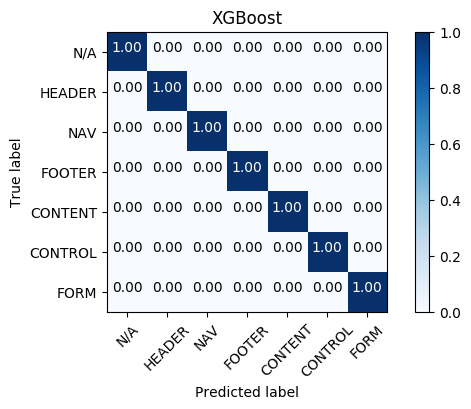

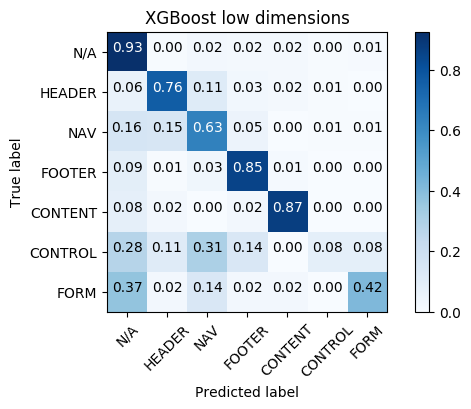

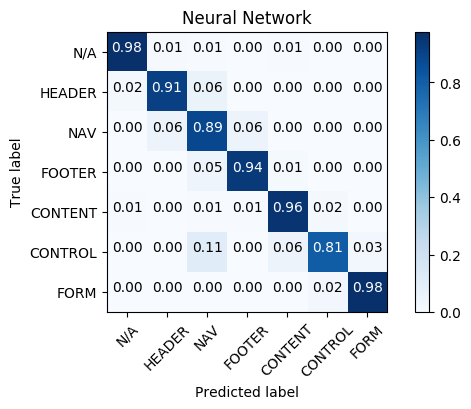

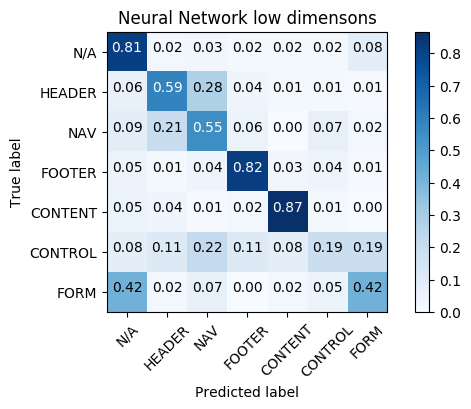

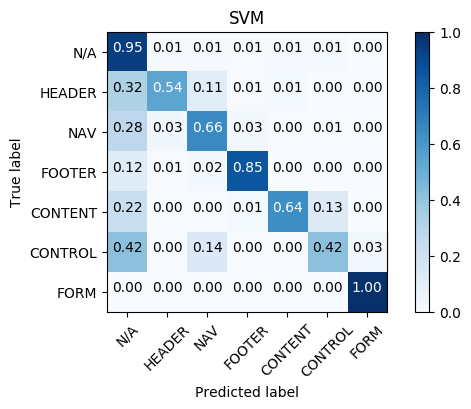

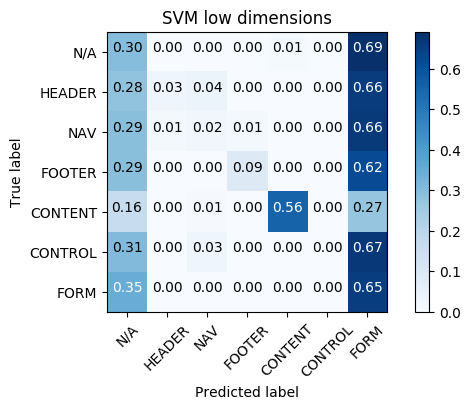

In [6]:
np.set_printoptions(precision=2)

plt.figure(dpi=100)
plot_confusion_matrix(xg_conf_mat, classes=CLASSES_NAMES, normalize=True,
                      title='XGBoost')
plt.figure(dpi=100)
plot_confusion_matrix(xg_conf_mat_small, classes=CLASSES_NAMES, normalize=True,
                      title='XGBoost low dimensions')
plt.figure(dpi=100)
plot_confusion_matrix(nn_conf_mat, classes=CLASSES_NAMES, normalize=True,
                      title='Neural Network')
plt.figure(dpi=100)
plot_confusion_matrix(nn_conf_mat_small, classes=CLASSES_NAMES, normalize=True,
                      title='Neural Network low dimensons')
plt.figure(dpi=100)
plot_confusion_matrix(svm_conf_mat, classes=CLASSES_NAMES, normalize=True,
                      title='SVM')
plt.figure(dpi=100)
plot_confusion_matrix(svm_conf_mat_small, classes=CLASSES_NAMES, normalize=True,
                      title='SVM low dimensions')

plt.show()